# Attractor computation 

This notebook illustrates how to use AEON.py to analyze attractors of a non-trivial Boolean network.

This notebook assumes that you already have a basic understanding of AEON.py as presented in the remianing notebooks in this folder. However, you should be able to follow this tutorial even if you have not read the remaining notebooks, just keep in mind that you can find more information about the presented features there.

We start by loading a relatively large Boolean network (66 variables, so `2^66` states):

In [1]:
from biodivine_aeon import *
from pathlib import Path

In [2]:
model = BooleanNetwork.from_file('butanol-pathway-fixed-inputs.aeon')

print(model)

BooleanNetwork(variables=66, regulations=139, explicit_parameters=0, implicit_parameters=0)


The model as we have it here has no parameters and all input variables have a fixed constant value. All of its update functions are also fully specified:

In [3]:
assert model.explicit_parameter_count() == 0 and model.implicit_parameter_count() == 0

for v in model.variables():
    print(model.get_variable_name(v), "=", model.get_update_function(v))
    assert model.get_update_function(v) is not None

3_hydroxybutyryl_CoA = crt | hbd | acetoacetyl_CoA
AbrB = !spo0A_p
EtfAB = NADH
NADH = true
NAD_P_H = true
PTS = true
Rnf = true
acetaldehyde = acetyl_CoA | ald
acetate = (pta & acetone) | (glucose___PTS & acetone) | ack
acetic_acid = acetyl_p & acetate & !sporulation
acetoacetate = ctfB | acetoacetyl_CoA | ctfA
acetoacetyl_CoA = ctfB | thlA | hbd | acetyl_CoA
acetone = (adc & !sporulation) | (acetoacetate & !sporulation)
acetyl_CoA = (acetate & acetoacetyl_CoA) | thlA | pyruvate | pfo
acetyl_p = acetyl_CoA
ack = !(spo0A_p | sporulation)
adc = spo0A_p
adhA = spo0A_p
adhB = spo0A_p
ald = spo0A_p | sigK
bcd = !(sporulation | spo0A_p)
bdhAB = spo0A_p
buk1 = !(sporulation | spo0A_p)
butanal = ald | butyryl_CoA | bdhAB
butanol = (bdhAB & !sporulation) | (adhB & !sporulation) | (butanal & !sporulation) | (adhA & !sporulation) | (NAD_P_H & !sporulation)
butyrate = (buk1 & !butyrate) | (glucose___PTS & !butyrate) | (ptb & !butyrate)
butyric_acid = butyryl_p & butyrate & !sporulation
butyryl_Co

We can compute the attractors of such model in a few seconds:

In [4]:
stg = AsynchronousGraph(model)

attractors = Attractors.attractors(stg)

attractors

[ColoredVertexSet(cardinality=27262976, colors=1, vertices=27262976, symbolic_size=109)]

We see that the model has one attractor, and this attractor has `~27.2e6` states. The set contains only one color, which is expected, since our model has no parameters or unspecified functions. Using symbolic operations, we can check if the attractor contains states with some specific properties. For example, in this model, `sporulation` is an important output of the network, and we may need to know if the attractor contains some states where sporulation is `True`, or even if all of the states have this property:

In [5]:
sporulation_on = stg.mk_subspace({ "sporulation": True })

on_in_attractor = attractors[0].intersect(sporulation_on).vertices().cardinality()
off_in_attractor = attractors[0].minus(sporulation_on).vertices().cardinality()

print("Sporulation is ON in", on_in_attractor, "states.")
print("Sporulation is OFF in", off_in_attractor, "states.")
print("Sporulation is ON in", round((on_in_attractor / (on_in_attractor + off_in_attractor)) * 100.0, 2), "% of attractor states.")

Sporulation is ON in 12582912 states.
Sporulation is OFF in 14680064 states.
Sporulation is ON in 46.15 % of attractor states.


Interesting! Now we can see that the state of `sporulation` can change in the attractor, and the ratio of states in which it is active.

We can build progressively more complex and deeper queries based on what we actually want to know about our set. However, if we want to just quickly show what the set looks like, we can always "dump" its underlying BDD into a `.dot` graph:

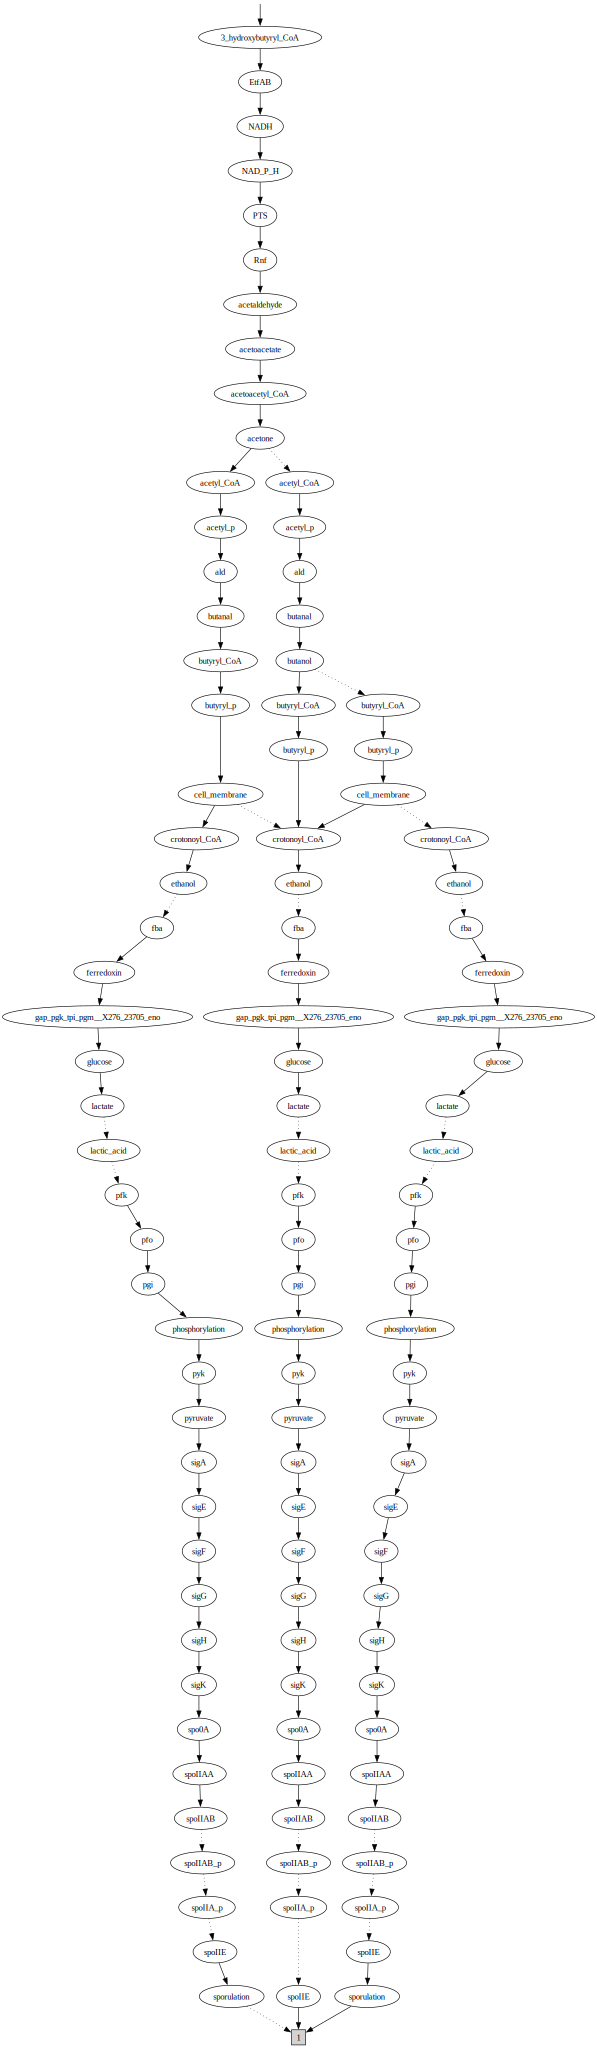

In [6]:
import graphviz

graphviz.Source(attractors[0].to_bdd().to_dot())

This presentation can be a bit confusing, but we can usually at least spot variables whose value is constant within the attractor (e.g. `PTS`, `fba`, etc.).

Now, let's look at how this situation changes when we introduce parameters. We start by "erasing" the update function of every constant state in our network:

In [7]:
for v in model.variables():
    if len(model.predecessors(v)) == 0:
        model.set_update_function(v, None)
        
# We can also achieve a similar effect by calling model.inline_inputs()

After we recompute our asynchrnous graph, we see that now we have 8192 colors, each corresponding to one possible valuation of the constant input variables:

In [8]:
stg = AsynchronousGraph(model)

stg.mk_unit_colored_vertices()

ColoredVertexSet(cardinality=604462909807314587353088, colors=8192, vertices=73786976294838206464, symbolic_size=2)

Now we can recompute the attractors for this new network (this operation can take up to a few minutes, since the new graph is much more complex):

In [9]:
attractors = Attractors.attractors(stg)
attractors

[ColoredVertexSet(cardinality=867718363543552, colors=6704, vertices=867718363543552, symbolic_size=5924),
 ColoredVertexSet(cardinality=15959465984, colors=1488, vertices=15959465984, symbolic_size=1393)]

In this result, we have two attractor sets! One with 6704 colors, and one with 1488 colors. This does not necessarily mean that some colors admit two attractors simultaneously (the fact that `6704 + 1488 = 8192` also suggests these two sets cover disjoint sets of colors). However, we can verify this just to be sure:

In [10]:
shared_colors = attractors[0].colors().intersect(attractors[1].colors())
print("Number of colors in both attractor sets:", shared_colors.cardinality())

Number of colors in both attractor sets: 0


And just as we suspected, there is no intersection between the two sets. This can happen due to how the underlying algorithm works: some stable states are detected first, and more complex attractors are detected afterwards. However, since there are no intersections between these two sets, we can unify them and consider them as a single attractor. 

Note that this effect is often even more pronounced as the number of attractors grows. That is, the length of the `attractors` array does not indicate the actual attractor count in any of the individual parametrisations, since multiple sets can cover disjoint sets of colors, as we saw here. However, `len(attractors)` is the upper bound on the attractor count in any color.

To better understand what is happening in this single attractor, we can classify its colors based on their long-term behaviour (this can also take a few second to compute):

In [11]:
attractor = attractors[0].union(attractors[1])

classes = Classification.classify_long_term_behavior(stg, attractor)
classes

{Class(["disorder"]): ColorSet(cardinality=6144, symbolic_size=4),
 Class(["stability"]): ColorSet(cardinality=2048, symbolic_size=4)}

As we can see, 2048 colors correspond to a stable state, and 6144 colors correspond to a disordered attractor. In this case, we have no oscillating attractors. We can now use these classes to split the `attractor` set based on its behaviour:

In [12]:
stable_attractor = attractor.intersect_colors(classes[Class("stability")])
disordered_attractor = attractor.intersect_colors(classes[Class("disorder")])

print(stable_attractor)
print(disordered_attractor)

ColoredVertexSet(cardinality=2048, symbolic_size=281)
ColoredVertexSet(cardinality=867734323007488, symbolic_size=5670)


Now, we can do the same analysis of the `sporulation` output as we did before, but accross all colors:

In [13]:
sporulation_on = stg.mk_subspace({ "sporulation": True })

on_in_stable_attractor = stable_attractor.intersect(sporulation_on).vertices().cardinality()
off_in_stable_attractor = stable_attractor.minus(sporulation_on).vertices().cardinality()

print("Sporulation is ON in", on_in_stable_attractor, "stable states.")
print("Sporulation is OFF in", off_in_stable_attractor, "stable states.")
print("Sporulation is ON in", round((on_in_stable_attractor / (on_in_stable_attractor + off_in_stable_attractor)) * 100.0, 2), "% of stable attractor states.")

on_in_disorder_attractor = disordered_attractor.intersect(sporulation_on).vertices().cardinality()
off_in_disorder_attractor = disordered_attractor.minus(sporulation_on).vertices().cardinality()

print("Sporulation is ON in", on_in_disorder_attractor, "disorder states.")
print("Sporulation is OFF in", off_in_disorder_attractor, "disorder states.")
print("Sporulation is ON in", round((on_in_disorder_attractor / (on_in_disorder_attractor + off_in_disorder_attractor)) * 100.0, 2), "% of disordered attractor states.")

Sporulation is ON in 2048 stable states.
Sporulation is OFF in 0 stable states.
Sporulation is ON in 100.0 % of stable attractor states.
Sporulation is ON in 335223420223488 disorder states.
Sporulation is OFF in 532510902784000 disorder states.
Sporulation is ON in 38.63 % of disordered attractor states.


Interestingly, we have discovered that in every stable state, `sporulation` is active. We can thus use this fact to pick a witness network which guarantees that eventually, `sporulation` will always be active in a stable attractor:

In [14]:
witness = next(iter(classes[Class("stability")])).instantiate(model)
print(witness)

BooleanNetwork(variables=66, regulations=139, explicit_parameters=0, implicit_parameters=0)


This witness network is completely specified (i.e. has no parameters or uninterpreted functions).

Finally, since computing the attractors can take a long time, it may be necessary to save them into a file for further processing. For this, we can export the underlying BDD representation:

In [15]:
Path("stable_attractor.bdd").write_text(stable_attractor.to_bdd().data_string());
Path("disordered_attractor.bdd").write_text(disordered_attractor.to_bdd().data_string());

With the BDDs saved, we can always reload them from disk. However, remeber that the BDD does not contain any information about the model! So you must make sure that you only import BDDs that were created using the same model:

In [16]:
ctx = stg.symbolic_context()
bdd_ctx = ctx.bdd_variable_set()
stable_reloaded = ColoredVertexSet(ctx, Bdd(bdd_ctx, Path("stable_attractor.bdd").read_text()))
disordered_reloaded = ColoredVertexSet(ctx, Bdd(bdd_ctx, Path("disordered_attractor.bdd").read_text()))

print(stable_reloaded)
print(disordered_reloaded)

assert stable_reloaded == stable_attractor
assert disordered_reloaded == disordered_attractor

ColoredVertexSet(cardinality=2048, symbolic_size=281)
ColoredVertexSet(cardinality=867734323007488, symbolic_size=5670)


As we can see, the sets are the same as the ones that we saved into the files.

Finally, let us quickly note that you can also compute reachability from/to a specific symbolic set. Furthermore, you can specify a subset within which the reachability should be computed. Using this mechanism, you can often build more complex analysis techniques, such as exploring the basins of attraction of individual attractors:

In [17]:
# Pick a colored vertex set with a single vertex.
vertex = stg.mk_unit_colored_vertices().pick_vertex()
print(vertex.vertices())

vertex_list = [v for v in vertex.vertices()]
print(vertex_list)

# The weak basin of the chosen vertex.
basin = Reachability.reach_bwd(stg, vertex)
print("Basin", basin)

# The SCC surrounding the chosen vertex (basin is used as a restriction within
# which the forward reachability is computed).
scc = Reachability.reach_fwd(stg, vertex).intersect(basin)
print("SCC", scc)

VertexSet(cardinality=1, symbolic_size=68)
[VertexModel({'3_hydroxybutyryl_CoA': 0, 'AbrB': 0, 'EtfAB': 0, 'NADH': 0, 'NAD_P_H': 0, 'PTS': 0, 'Rnf': 0, 'acetaldehyde': 0, 'acetate': 0, 'acetic_acid': 0, 'acetoacetate': 0, 'acetoacetyl_CoA': 0, 'acetone': 0, 'acetyl_CoA': 0, 'acetyl_p': 0, 'ack': 0, 'adc': 0, 'adhA': 0, 'adhB': 0, 'ald': 0, 'bcd': 0, 'bdhAB': 0, 'buk1': 0, 'butanal': 0, 'butanol': 0, 'butyrate': 0, 'butyric_acid': 0, 'butyryl_CoA': 0, 'butyryl_p': 0, 'cell_membrane': 0, 'crotonoyl_CoA': 0, 'crt': 0, 'ctfA': 0, 'ctfB': 0, 'ethanol': 0, 'fba': 0, 'ferredoxin': 0, 'gap_pgk_tpi_pgm__X276_23705_eno': 0, 'glucose': 0, 'glucose___PTS': 0, 'hbd': 0, 'lactate': 0, 'lactic_acid': 0, 'pfk': 0, 'pfo': 0, 'pgi': 0, 'phosphorylation': 0, 'pta': 0, 'ptb': 0, 'pyk': 0, 'pyruvate': 0, 'sigA': 0, 'sigE': 0, 'sigF': 0, 'sigG': 0, 'sigH': 0, 'sigK': 0, 'spo0A': 0, 'spo0A_p': 0, 'spoIIAA': 0, 'spoIIAB': 0, 'spoIIAB_p': 0, 'spoIIA_p': 0, 'spoIIE': 0, 'sporulation': 0, 'thlA': 0})]
Basin Colo

For example, for an initial state where all variables are inactive, we can see that its (weak) basin is quite large, but the vertex is in fact a trivial SCC (the whole component is one vertex). 


So far, this is the end of our demo. In case of any issues, feel free to contact us on github!